In [12]:
import tqdm
import numpy as np
import scipy
import matplotlib.pyplot as plt

import sys
sys.path.insert(0, "../")
from methods import Hexagon

import jax
import jax.numpy as jnp
from jax.scipy.optimize import minimize

In [13]:
# utilities
def rotate(x, theta):
    m = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
    return m@x

def relu(x):
    return jnp.maximum(0, x)

In [14]:
# 🔪 JAX 🔪
def grid_func(r, k, phi):
    rhat = r[None] - phi
    kr = jnp.tensordot(rhat, k, axes = (-1, -1))
    #g = relu(1/len(k)*jnp.sum(jnp.cos(kr), axis = -1))#+1/len(k))
    g = jnp.sum(jnp.cos(kr), axis = -1)
    return g

def jacobian(r, k, phi):
    return jax.jacfwd(grid_func)(r, k, phi) # default is zeroth argument of function

def jacobian_determinant(r, k, phi):
    J = jacobian(r, k, phi)
    return jnp.sqrt(jnp.linalg.det(jnp.dot(J.T, J)))

def jacobian_determinant_jacobian(r,k,phi):
    return jax.jacfwd(jacobian_determinant)(r, k, phi)

def batch_jacobian_determinant_jacobian(r,k,phi):
    return jax.vmap(jacobian_determinant_jacobian,(0,None,None))(r,k,phi)

def batch_jacobian_determinant(r, k, phi):
    return jax.vmap(jacobian_determinant, (0, None, None))(r, k, phi)

def batch_grid_func(r, k, phi):
    return jax.vmap(grid_func, (0, None, None))(r, k, phi)

In [15]:
def loss(phi_in, r, k, nc):
    jnp.reshape(phi_in, (nc, 2))
    return jnp.mean((batch_jacobian_determinant_jacobian(r, k, phi))**2)

def variance(r, k, phi):
    det = batch_jacobian_determinant(r, k, phi)
    mu = jnp.mean(det)
    return jnp.mean((mu - det)**2)

In [16]:
# Save jacobian determinant pre-training
n_samples = 100
x = np.linspace(-2, 2, n_samples, endpoint = False) # nice and big region for eval
y = np.linspace(-2, 2, n_samples, endpoint = False)
xx, yy = np.meshgrid(x, y)
u = jnp.stack([xx.ravel(), yy.ravel()], axis = -1).astype("float32")

In [17]:
def init_model(n, n_waves = 3, theta = np.pi/3, random_seed = True):
    # make model parameters
    if random_seed:  
        key = jax.random.PRNGKey(np.random.randint(0, int(1e16))) # random seed
        key, subkey = jax.random.split(key)
    else:
        key = jax.random.PRNGKey(0) # random seed ish
        subkey = key
        
    f = 1
    k = 2*np.pi*f*jnp.array([rotate(np.array([1,0]), i*theta) for i in range(n_waves)])
    hexagon = Hexagon(f/np.sqrt(3), 0, np.zeros(2))  
    phi = jnp.array(hexagon.sample(n))
    return key, k, phi, hexagon

key, k, phi, hexagon = init_model(1000)
phi0 = np.copy(phi)

det_J_pre_train = np.array(batch_jacobian_determinant(u, k, phi))
det_J_pre_train = np.reshape(det_J_pre_train, (n_samples, n_samples))

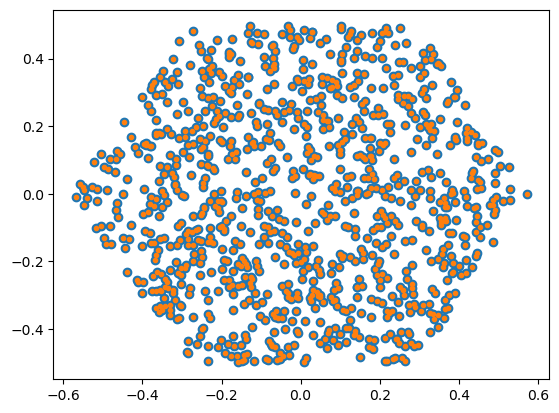

In [20]:
plt.plot(phi[:,0], phi[:,1], "o")
plt.plot(phi0[:,0], phi0[:,1], ".")

In [21]:
det_J = np.array(batch_jacobian_determinant(u, k, phi))
det_J = np.reshape(det_J, (n_samples, n_samples))

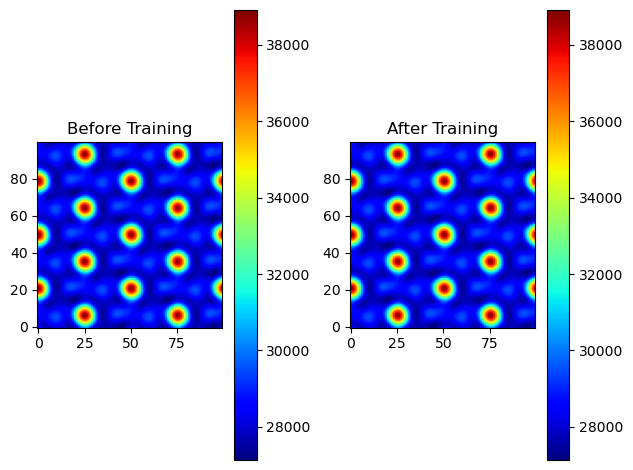

In [22]:
# visualize Jacobian determinants before/after training
fig, axs = plt.subplots(1, 2)
im0 = axs[0].imshow(det_J_pre_train, origin = "lower", cmap = "jet")
im1 = axs[1].imshow(det_J, origin = "lower", cmap = "jet") 
axs[0].set_title("Before Training")
axs[1].set_title("After Training")
fig.colorbar(im0, ax = axs[0]) # beauty
fig.colorbar(im1, ax = axs[1])
plt.tight_layout()

In [23]:
# Save jacobian determinant pre-training
n_samples = 100
x = np.linspace(-2, 2, n_samples, endpoint = False) # nice and big region for eval
y = np.linspace(-2, 2, n_samples, endpoint = False)
xx, yy = np.meshgrid(x, y)
u = jnp.stack([xx.ravel(), yy.ravel()], axis = -1).astype("float32")
z = batch_grid_func(u, k, phi0)

In [24]:
im = z.reshape(100,100, -1)

(10000,)


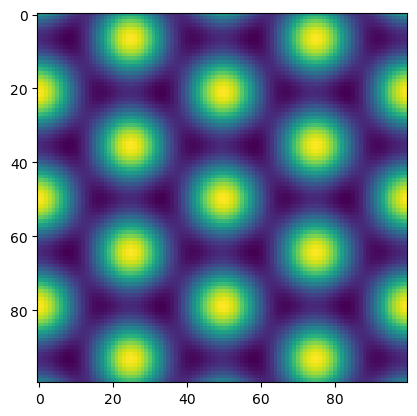

In [30]:
#zdiff = np.linalg.norm(im- grid_func(jnp.array([0,0]),k,phi0),axis=-1)
z_prod = jnp.tensordot(z, grid_func(jnp.array([0,0]),k,phi0), axes = (-1, -1))
print(z_prod.shape)
plt.imshow(z_prod.reshape(100,100))
